# 3 時間目
# フィルタを使って学習機械を作ってみよう（続き）

それでは，畳込みニューラルネットワークを，多段化して深層畳み込みニューラルネットワーク (Deep Convolution Neural Network) を実現してみましょう．

基本的には `model` の部分を繰り返すという話になります．
前の時間のものは *初期視覚野* のモデルとして畳み込みネットワークを作りいましたが，高次視覚野をモデル化させるために
初期視覚野と同じような構造を用意してやるだけです．

In [1]:
# とりあえずはおまじない
import numpy as np
import matplotlib.pylab as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## データを用意する．

データは先程と同じく MNIST を用います．

In [2]:
from keras.datasets import mnist

(x_train, y_train_label), (x_test, y_test_label) = mnist.load_data()

# このままだと扱いにくいので画像データは [0, 1] の値を持つデータにします．
x_train = x_train.astype('float32').reshape(60000, 28, 28, 1)
x_test = x_test.astype('float32').reshape(10000, 28, 28, 1)
x_train /= 255
x_test /= 255

# ラベルデータもちょっと扱いにくいので 10 要素のベクトルで表す (one-hot vector 表現)
y_train = keras.utils.to_categorical(y_train_label)
y_test = keras.utils.to_categorical(y_test_label)

## 視覚モデルを構築してみる．

高次視覚野のモデルとしては，初期視覚野的のモデルを繰り返し適用することで作り出します．
あまり大規模なものにすると計算時間がかかるので，ここでは，初期視覚野の構造を2回繰り返すことを考えます．

In [3]:
model = Sequential()

# 初期視覚野の部分は前述の model と同じ
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# 高次視覚野は上記の初期視覚野の部分を繰り返し作る
model.add(Conv2D(16, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

Instructions for updating:
Colocations handled automatically by placer.


ここまでで，高次視覚野のモデルになっていると思うことにしましょう．
この表現を分類器にかけてみるのは，前のモデルと一緒です．

In [4]:
# 分類器，とりあえずはおまじないと思っておｋ

model.add(Flatten()) # 上記表現を1列のベクトルに並べて
model.add(Dense(10, activation='softmax')) # 識別器を構成

## モデルの学習

さて，ここまででモデルができました．でもフィルタの係数とかは決まってません．この部分を学習で決めることにします．
学習自体は，ある種の関数(loss関数と呼ばれます)を小さくすることで求めます．
ここでは `categorical_crossentropy` と呼ばれるを loss 関数としています．

In [5]:
from keras.optimizers import Adam

# 学習モデルを定義して
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 学習させます
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
60000/60000 [==============================] - 13s 212us/step - loss: 0.4164 - acc: 0.8844
Epoch 2/20
60000/60000 [==============================] - 13s 209us/step - loss: 0.1151 - acc: 0.9653
Epoch 3/20
60000/60000 [==============================] - 13s 212us/step - loss: 0.0863 - acc: 0.9745
Epoch 4/20
60000/60000 [==============================] - 13s 218us/step - loss: 0.0732 - acc: 0.9780
Epoch 5/20
60000/60000 [==============================] - 14s 230us/step - loss: 0.0641 - acc: 0.9808
Epoch 6/20
60000/60000 [==============================] - 13s 211us/step - loss: 0.0574 - acc: 0.9825
Epoch 7/20
60000/60000 [==============================] - 13s 220us/step - loss: 0.0526 - acc: 0.9840
Epoch 8/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0485 - acc: 0.9850
Epoch 9/20
60000/60000 [==============================] - 13s 223us/step - loss: 0.0457 - acc: 0.9857
Epoch 10/20
60000/60000 [=========

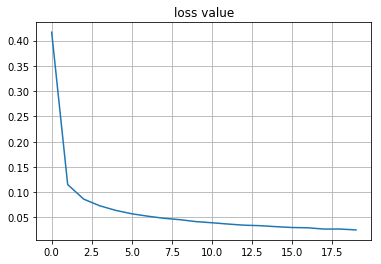

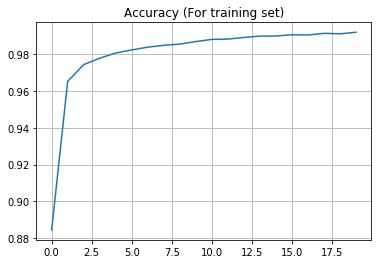

In [6]:
# loss の値
plt.figure()
plt.plot(history.history['loss'])
plt.title('loss value')
plt.grid()


# 学習データに対する正答率
plt.figure()
plt.plot(history.history['acc'])
plt.title('Accuracy (For training set)')
plt.grid()


大体同程度の識別精度になっていることがわかると思われます．
次にテストセットで評価してみましょう

In [7]:
# テストセットで評価してみる

score = model.evaluate(x_test, y_test, verbose=1)

print('test loss: ', score[0])
print('test accuracy: ', score[1])

10000/10000 [==============================] - 1s 78us/step
test loss:  0.0393314706997131
test accuracy:  0.9872


おおよそ 98 % 程度の精度（が出るはず）であるので，まぁまぁのものができた．

ついでに，間違えたやつをピックアップしてみよう．

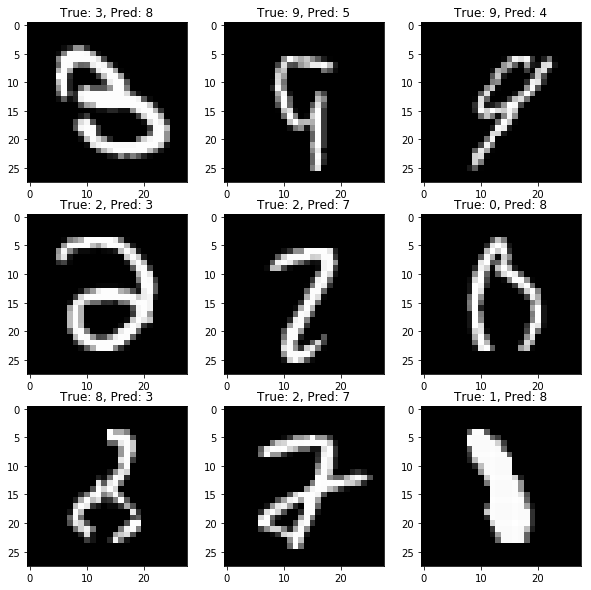

In [8]:
# 識別間違いしたやつをピックアップしてみる
y_pred_label = model.predict_classes(x_test)

idx = (y_pred_label != y_test_label) # 答えが違う添字のやつを抜き出し
x_failed = x_test[idx]
y_true_failed = y_test_label[idx]
y_pred_failed = y_pred_label[idx]

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_failed[i, :, :, 0], cmap='gray')
    plt.title('True: %d, Pred: %d' % (y_true_failed[i], y_pred_failed[i]))
